# Variables for Hypothesis Testing 


## Introduction

In [554]:
#!python -m pip install libpysal

In [555]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import networkx as nx
from collections import defaultdict

# Load Data
df_w1 = pd.read_csv('../Cooked/df_w1_prepared.csv')
df_w2 = pd.read_csv('../Cooked/df_w2_prepared.csv') 
df_w3 = pd.read_csv('../Cooked/df_w3_prepared.csv')

G_1 = nx.read_gml("../NA/multiplex_graph_w1.gml")
G_2 = nx.read_gml("../NA/multiplex_graph_w2.gml")
G_3 = nx.read_gml("../NA/multiplex_graph_w3.gml")

In [582]:
G_1.edges(data=True, keys=True)

OutMultiEdgeDataView([('39b', 'k9w', 'aquaintance', {'type': 'aquaintance'}), ('39b', 'k9w', 'leftright', {'type': 'leftright', 'weight': 3.0}), ('39b', 'k9w', 'politics', {'type': 'politics'}), ('39b', 'k9w', 'council', {'type': 'council'}), ('39b', 'tuw', 'aquaintance', {'type': 'aquaintance'}), ('39b', 'tuw', 'leftright', {'type': 'leftright', 'weight': 5.0}), ('39b', 'tuw', 'council', {'type': 'council'}), ('39b', 'ebs', 'aquaintance', {'type': 'aquaintance'}), ('39b', 'ebs', 'leftright', {'type': 'leftright', 'weight': 6.0}), ('39b', 'ebs', 'council', {'type': 'council'}), ('39b', 'ech', 'aquaintance', {'type': 'aquaintance'}), ('39b', 'ech', 'leftright', {'type': 'leftright', 'weight': 7.0}), ('39b', 'ech', 'politics', {'type': 'politics'}), ('39b', 'ech', 'council', {'type': 'council'}), ('k9w', 'tuw', 'aquaintance', {'type': 'aquaintance'}), ('k9w', 'tuw', 'leftright', {'type': 'leftright', 'weight': 3.0}), ('k9w', 'tuw', 'value', {'type': 'value'}), ('k9w', 'tuw', 'politics', 

In [618]:
import pandas as pd
import networkx as nx

def create_focused_edges_dataframe(graphs, relations, attribute_weighted="leftright", node_attributes=None):
    if node_attributes is None:
        node_attributes = ["linksrechts_self"]
    
    if "leftright" not in relations:
        relations.append("leftright")
    
    all_edges = []
    
    for time_idx, G in enumerate(graphs, 1):
        # First pass: only process leftright edges
        leftright_edges = [
            (u, v, k) for u, v, k, d in G.edges(data=True, keys=True)
            if k == "leftright"
        ]
        
        if not leftright_edges:
            continue
            
        filtered_graph = G.edge_subgraph(leftright_edges).copy()
        
        for u, v, d in filtered_graph.edges(data=True):
            edge_entry = {
                "time": time_idx,
                "i": u,
                "j": v,
                "linksrechts_ij": d.get("weight", None),
            }
            
            # Add node attributes only for leftright edges
            for attr in node_attributes:
                edge_entry[f"{attr}_i"] = filtered_graph.nodes[u].get(attr)
                edge_entry[f"{attr}_j"] = filtered_graph.nodes[v].get(attr)
            
            # Second pass: check for other relations between these nodes
            for rel in relations:
                if rel == "leftright":
                    continue
                
                # Check if this relation exists between the nodes
                if G.has_edge(u, v, key=rel):
                    rel_data = G.edges[u, v, rel]
                    edge_entry[rel] = True
                else:
                    edge_entry[rel] = False
            
            all_edges.append(edge_entry)
    
    # Create DataFrame
    df = pd.DataFrame(all_edges)
    
    # Reorder columns for better readability
    base_cols = ["time", "i", "j", "linksrechts_ij"]
    node_cols = [f"{attr}_i" for attr in node_attributes] + [f"{attr}_j" for attr in node_attributes]
    rel_cols = [rel for rel in relations if rel != "leftright"]
    
    return df[base_cols + node_cols + rel_cols]

# Example usage:
relations = ["aquaintance", "leftright", "politics", "council", "study", "friend", "value"]
graphs = [G_1, G_2, G_3]
node_attributes = ["grade", "gender", "linksrechts_self"]

total_edges_df = create_focused_edges_dataframe(
    graphs=graphs,
    relations=relations,
    attribute_weighted="leftright",
    node_attributes=node_attributes
)

In [595]:
relations = ["aquaintance", "leftright", "politics", "council", "study", "friend", "value"]
graphs = [G_1, G_2, G_3]
attribute_weighted = "leftright"
attribute = ["grade", "gender"]


filtered_edges = [
    (u, v, k) for u, v, k, d in G.edges(data=True, keys=True)
    if k == relation
]

filtered_graph_edges = G.edge_subgraph(filtered_edges).copy()

# Create a list to store edge data
edge_data = []

# Iterate through all edges in the filtered graph
for u, v, d in filtered_graph_edges.edges(data=True):
    edge_data.append({
        "i": u,
        "j": v,
        "leftright_i": filtered_graph_edges.nodes[u].get("linksrechts_self", None),
        "leftright_ij": d.get("weight", None),  # or d.get("leftright", None) if that's your attribute name
        "leftright_j": filtered_graph_edges.nodes[v].get("linksrechts_self", None),
        "aquaintance": , #True/False
        "friend": ,
        "value": ,
        "study": ,
        "poltics": ,
        "council": ,
    })

# Create DataFrame
edges_df = pd.DataFrame(edge_data)

# Display the first few rows
print(edges_df)


       i    j  leftright_i  leftright_ij  leftright_j
0    39b  k9w          3.0           3.0          5.0
1    39b  tuw          3.0           5.0          3.0
2    39b  ebs          3.0           6.0          4.0
3    39b  ech          3.0           7.0          8.0
4    k9w  tuw          5.0           3.0          3.0
..   ...  ...          ...           ...          ...
584  wrc  np4          4.0           4.0          5.0
585  rht  ucp          4.0           4.0          4.0
586  rht  vrm          4.0           3.0          3.0
587  rht  3eh          4.0           5.0          4.0
588  rbc  vnb          5.0           5.0          7.0

[589 rows x 5 columns]


***
## Assortativity (Homophily) of Attributes

 aggregated variable, build indexes , participation, efficacy... 

 variance anschauen und filter, niedrige rausschmeißen!

Entstehung des Netzwerks
 
 Wahrnehmung vs. Self und dann nochmal Assortativität 
 - setze die Wahrnehmung als Attribut des Knotens 

In [556]:
numeric_attributes = [
    "grade", "linksrechts_self", "age",
    "politics_question_one", "politics_question_two", "politics_question_three", # Sum score for all for all of them 
    "politics_question_four", "politics_question_five", "politics_question_six",
    "rent", "income", "postcode",
    "lr_CDU", "lr_CSU", "lr_SPD", "lr_Gruene", "lr_FDP", "lr_Linke", "lr_AfD", "lr_BSW",
    "scalo_cdu", "scalo_spd", "scalo_gruene", "scalo_fdp", "scalo_afd", "scalo_linke",
    "scalo_pep1", "scalo_pep2", "scalo_pep3", "scalo_pep4", "scalo_pep5", "scalo_pep6",
    "scalo_pep7", "scalo_pep8", "scalo_pep9", "scalo_pep10", "scalo_pep11", "scalo_pep12",
    "scalo_pep13", "scalo_pep14", "scalo_pep15"
]

categorical_attributes = ["gender", "lang", "tutorial", "device_type", "operating_system", "browser", "use_of_device", "ocu_mother", "ocu_father", "study_program", "participation_demonstration", "petition_signatory", "edu_father", "edu_mother", "social_networks_1", "social_networks_2", "social_networks_3",
                            "social_networks_4", "social_networks_5", "social_networks_6", #freshcamp!!! 
                            "social_networks_7", "social_networks_8", "social_networks_9"]

relations = ["aquaintance", "friend", "value", "study", "politics", "council"]

graphs = [G_1, G_2, G_3]

In [557]:
from matplotlib.patches import Rectangle

def assortativity_by_relation_by_attribute(graph, relation, attribute, is_numeric):
    # Step 1: Filter edges by edge key (relation)
    filtered_edges = [
        (u, v, k) for u, v, k, d in graph.edges(data=True, keys=True)
        if k == relation
    ]

    # Step 2: Create subgraph
    filtered_graph_edges = graph.edge_subgraph(filtered_edges).copy()

    # Step 3: Only keep edges with both nodes having the attribute
    valid_edges = [
        (u, v) for u, v in filtered_graph_edges.edges()
        if attribute in filtered_graph_edges.nodes[u] and
           attribute in filtered_graph_edges.nodes[v]
    ]

    # Step 4: Build filtered graph
    filtered_graph_nodes = nx.DiGraph()
    filtered_graph_nodes.add_edges_from(valid_edges)
    for n in filtered_graph_nodes.nodes:
        filtered_graph_nodes.nodes[n][attribute] = filtered_graph_edges.nodes[n][attribute]

    # Step 5: Calculate assortativity
    if filtered_graph_nodes.number_of_edges() == 0:
        return None
    try:
        if is_numeric:
            return nx.numeric_assortativity_coefficient(filtered_graph_nodes, attribute)
        else:
            return nx.attribute_assortativity_coefficient(filtered_graph_nodes, attribute)
    except Exception:
        return None

In [558]:
all_attributes = [(attr, True) for attr in numeric_attributes] + [(attr, False) for attr in categorical_attributes]

assortativity_results = {
    (f"G_{i+1}", relation, attr): assortativity_by_relation_by_attribute(G, relation, attr, is_numeric)
    for i, G in enumerate(graphs)
    for relation in relations
    for attr, is_numeric in all_attributes
}

In [559]:
df = pd.DataFrame([
    {"graph": g, "relation": r, "attribute": a, "assortativity": v}
    for (g, r, a), v in assortativity_results.items()
])

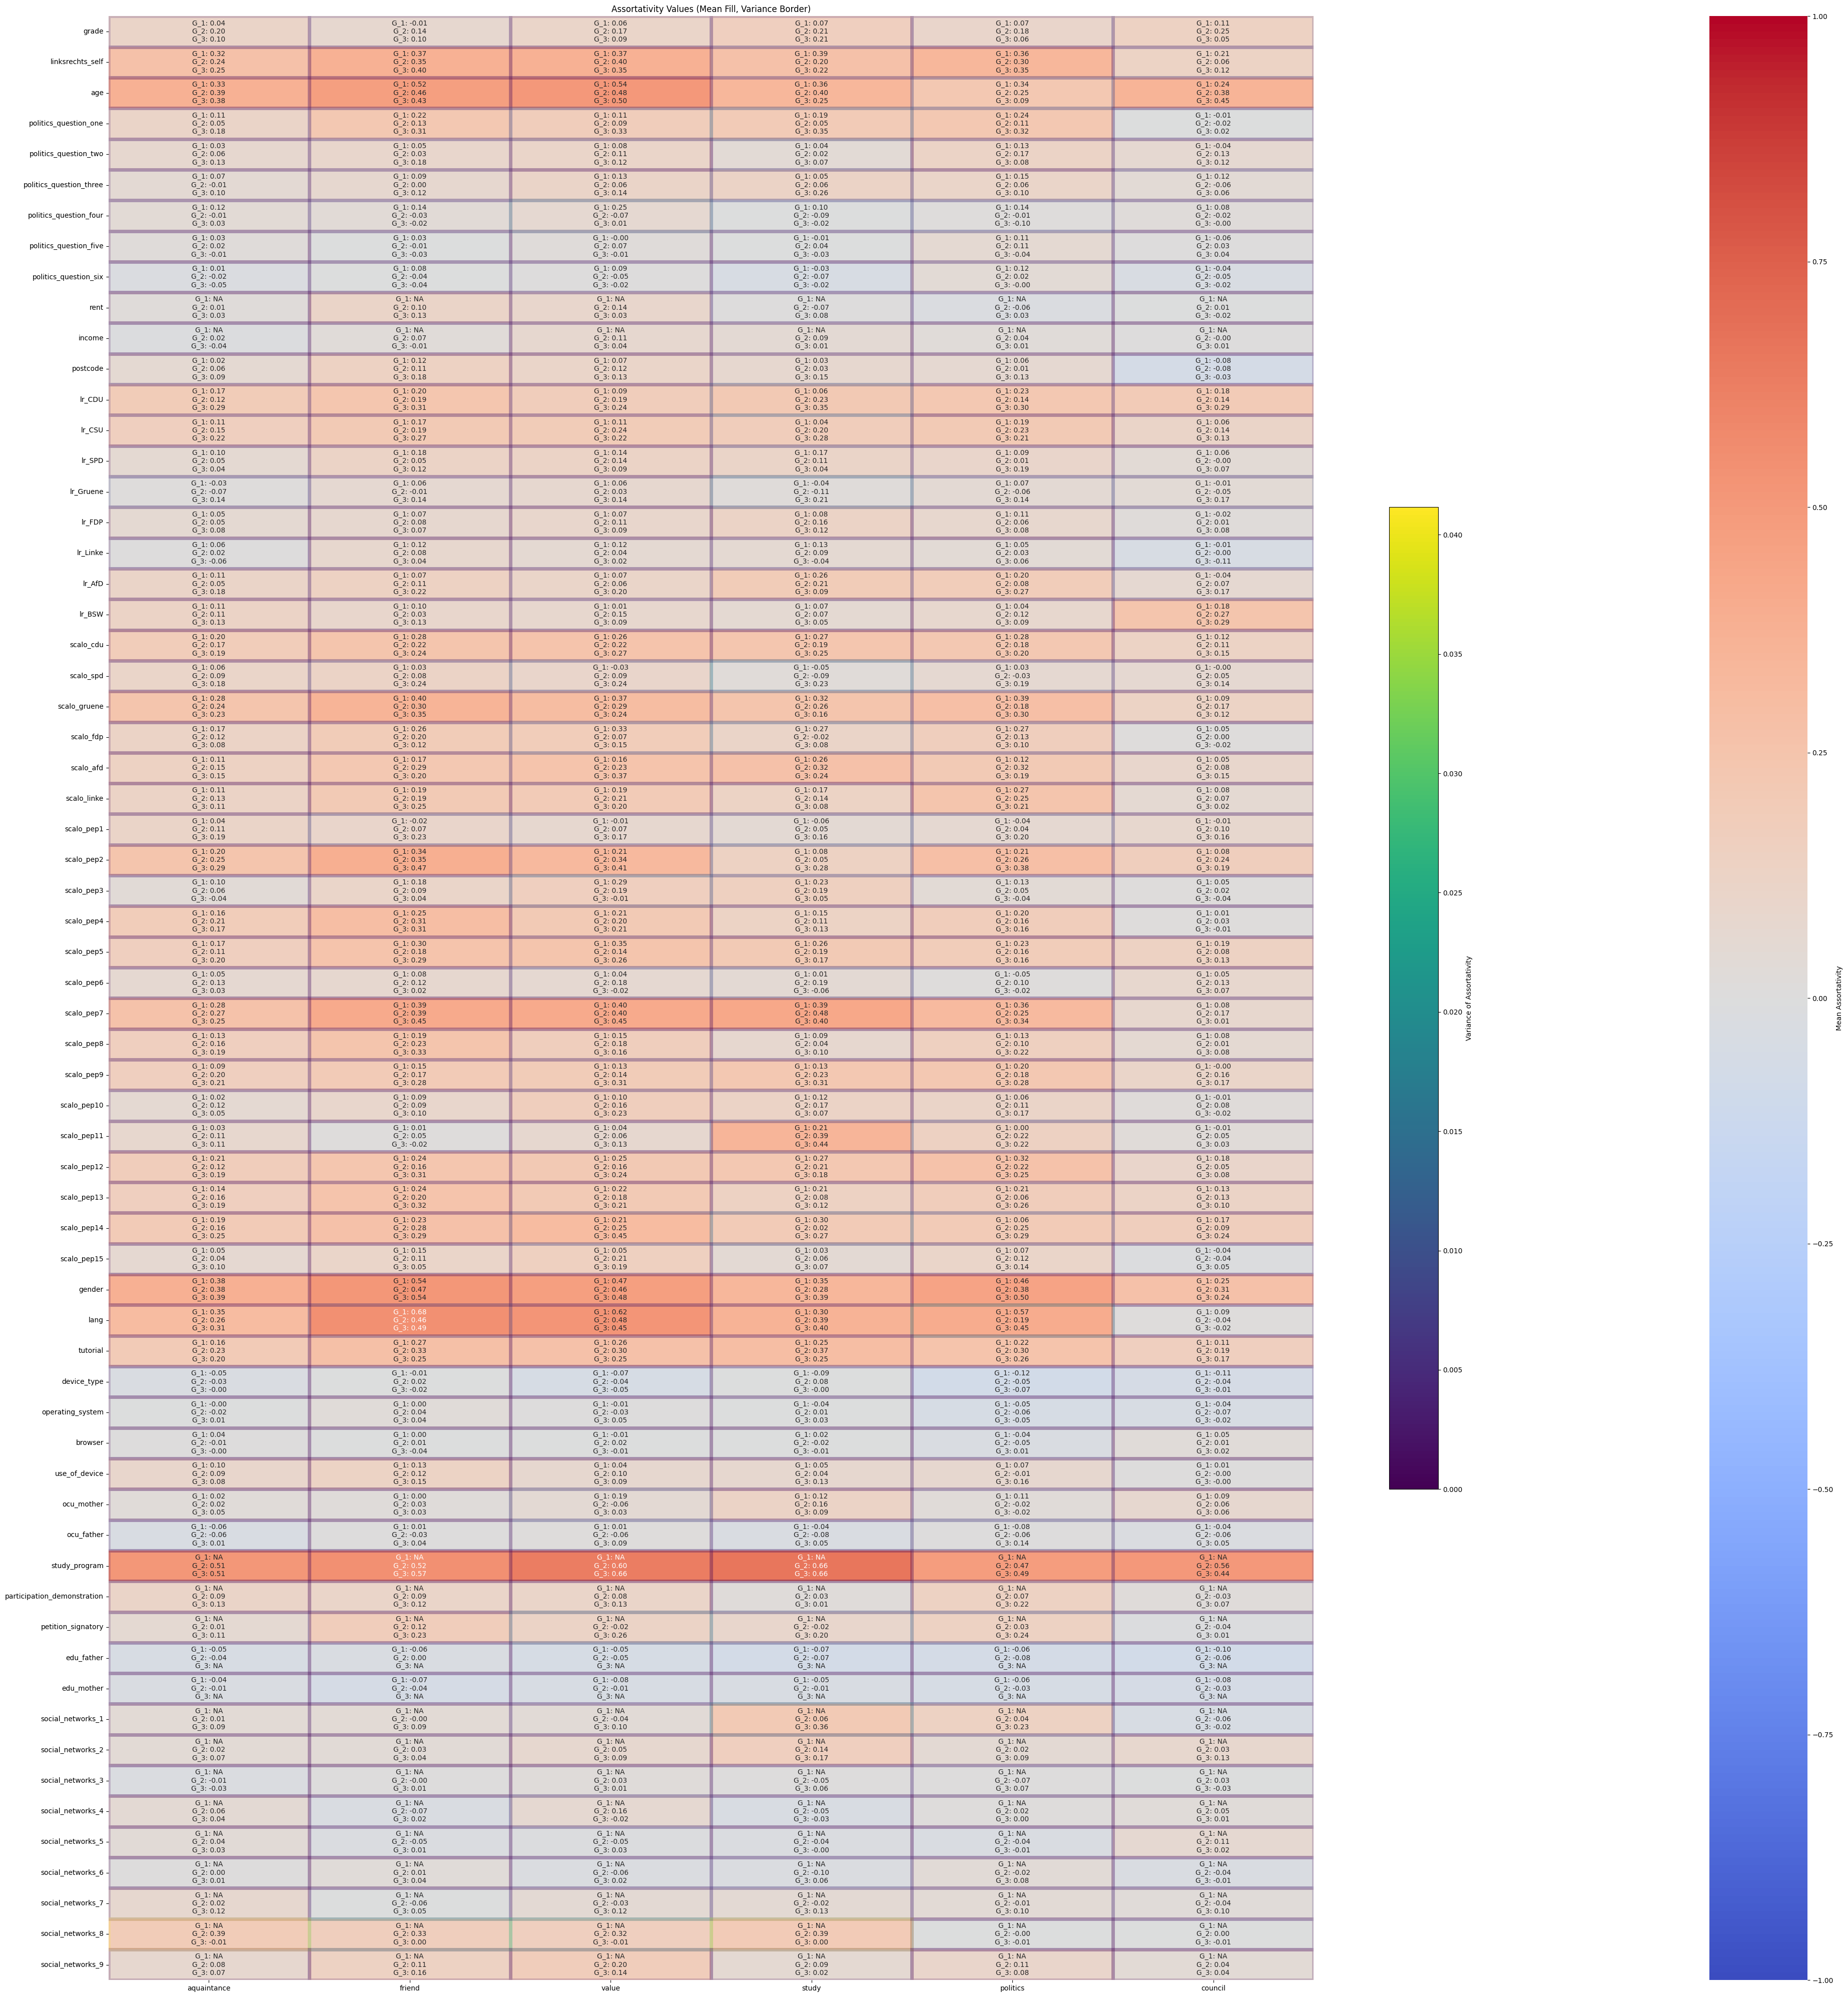

In [560]:
# Step 1: Pivot each graph's data into a separate DataFrame
graphs = df["graph"].unique()
pivot_dfs = {}

for graph_name in graphs:
    pivot_df = df[df["graph"] == graph_name].pivot(index="attribute", columns="relation", values="assortativity")
    pivot_dfs[graph_name] = pivot_df

# Step 2: Get the union of all attributes and relations
all_attributes = df["attribute"].unique()
all_relations = df["relation"].unique()

# Step 3: Build a DataFrame with combined strings for each cell
combined_matrix = pd.DataFrame(index=all_attributes, columns=all_relations, dtype=object)

for attr in all_attributes:
    for rel in all_relations:
        cell_values = []
        for graph_name in graphs:
            val = pivot_dfs.get(graph_name, pd.DataFrame()).get(rel, pd.Series()).get(attr, None)
            if pd.isna(val):
                display_val = "NA"
            else:
                display_val = f"{val:.2f}"
            cell_values.append(f"{graph_name}: {display_val}")
        combined_matrix.loc[attr, rel] = "\n".join(cell_values)

# Step 4: Compute mean and variance matrices
mean_matrix = pd.DataFrame(index=all_attributes, columns=all_relations, dtype=float)
variance_matrix = pd.DataFrame(index=all_attributes, columns=all_relations, dtype=float)

for attr in all_attributes:
    for rel in all_relations:
        vals = []
        for graph_name in graphs:
            val = pivot_dfs.get(graph_name, pd.DataFrame()).get(rel, pd.Series()).get(attr, np.nan)
            if not pd.isna(val):
                vals.append(val)
        mean_matrix.loc[attr, rel] = np.nanmean(vals) if vals else np.nan
        variance_matrix.loc[attr, rel] = np.nanvar(vals) if len(vals) >= 2 else np.nan

# Step 5: Plot the heatmap
plt.figure(figsize=(40, 40))

# Create heatmap for mean values (fill color)
ax = sns.heatmap(
    mean_matrix,
    annot=combined_matrix,
    fmt="",
    center=0,
    cmap="coolwarm",
    linewidths=0,  # No default grid lines (we'll add borders manually)
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Mean Assortativity"}
)

# Normalize variance for border color (0 to 1)
norm_variance = plt.Normalize(vmin=0, vmax=np.nanmax(variance_matrix.values))
cmap = plt.get_cmap("viridis")  # Colormap for variance

# Add borders based on variance
for i, attr in enumerate(all_attributes):
    for j, rel in enumerate(all_relations):
        var = variance_matrix.loc[attr, rel]
        if not np.isnan(var):
            # Get color from variance
            color = cmap(norm_variance(var))
            # Draw a rectangle border
            rect = Rectangle(
                xy=(j, i),
                width=1,
                height=1,
                fill=False,
                edgecolor=color,
                linewidth=5,  # Adjust border thickness
                alpha=0.2
            )
            ax.add_patch(rect)

# Add colorbar for variance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_variance)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Variance of Assortativity", shrink=0.5)

plt.title("Assortativity Values (Mean Fill, Variance Border)")
plt.tight_layout()
plt.show()

***
## Visualization: Political-Self-Assessment over Waves

- scale only ranged form 1 to 11 
- "0" values are missings!

In [561]:
def political_identity(df):
    dict_political_identity = {}

    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        # If self_identity is 0 or NaN, set to NaN
        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
        }
    return dict_political_identity

In [562]:
dict_polident_w1 = political_identity(df_w1)
dict_polident_w2 = political_identity(df_w2)
dict_polident_w3 = political_identity(df_w3)

In [563]:
# delta_ego_alter für Susumu, am besten mit abs() delta und nicht plus/minus 

# Build a DataFrame
df_ego = pd.DataFrame({
    'w1': {pid: data['ego'] for pid, data in dict_polident_w1.items()},
    'w2': {pid: data['ego'] for pid, data in dict_polident_w2.items()},
    'w3': {pid: data['ego'] for pid, data in dict_polident_w3.items()},
})

df_ego.index.name = 'participant_id'
df_ego = df_ego.reset_index()
df_ego_complete = df_ego.dropna()

df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True) 

df_long = df_ego_complete.melt(id_vars='participant_id', 
                      value_vars=['w1', 'w2', 'w3'],
                      var_name='wave', 
                      value_name='ego_score')

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_46943/4294299729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True)


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_46943/1819087568.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


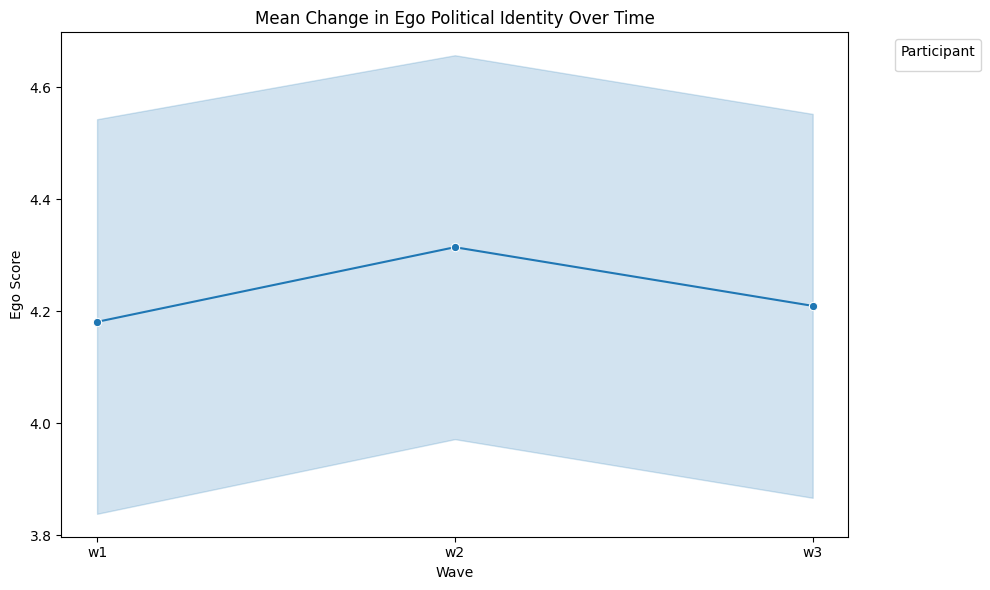

In [564]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='wave', y='ego_score', marker='o')
plt.title('Mean Change in Ego Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_46943/1735861286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm').reversed()


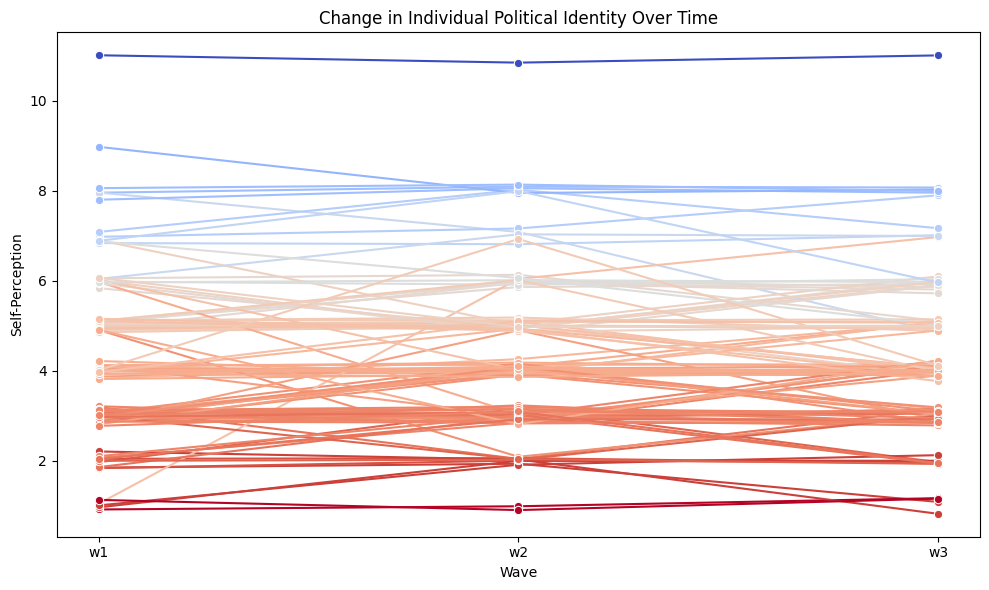

In [565]:
#### Step 1: Get average ego_score per participant!!!
participant_means = df_long.groupby('participant_id')['ego_score'].mean()

# Step 2: Normalize these scores
norm = Normalize(vmin=participant_means.min(), vmax=participant_means.max())

# Step 3: Get the colormap (blue-white-red)
cmap = get_cmap('coolwarm').reversed()

# Step 4: Map each participant to a color
participant_colors = {pid: cmap(norm(score)) for pid, score in participant_means.items()}

jitter_strength = 0.1
df_long['ego_jittered'] = df_long['ego_score'] + np.random.normal(0, jitter_strength, size=len(df_long))

# Step 5: Plot each line individually with its mapped color
plt.figure(figsize=(10, 6))
for pid, group in df_long.groupby('participant_id'):
    sns.lineplot(data=group, x='wave', y='ego_jittered', marker='o',
                 color=participant_colors[pid])

plt.title('Change in Individual Political Identity Over Time')
plt.ylabel('Self-Perception')
plt.xlabel('Wave')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()


***
## Creation: Variables for Analysis 

- Try to use the Graphs for the same task
- Keys for the dictionaries are allways the 3-Sign-Codes

In [566]:
graphs_by_wave = {
    "w1": G_1,
    "w2": G_2,
    "w3": G_3,
}

In [567]:
def collect_polident_self_perceptions(graphs_by_wave):
    """
    Returns a dictionary mapping each wave label to the self-perception dictionary.
    
    Structure:
    {
        wave_label: { node_id: self_identity_value_or_nan, ... },
        ...
    }
    """
    result = {}
    for wave_label, graph in graphs_by_wave.items():
        self_dict = {
            node: (value if value != 0 else np.nan)
            for node, value in graph.nodes(data="linksrechts_self")
        }
        result[wave_label] = self_dict
    return result

polident_self_perceptions = collect_polident_self_perceptions(graphs_by_wave)

In [568]:
from collections import defaultdict

def collect_all_polident_perceptions(graphs_by_wave, relation_types):
    """
    Returns a nested dictionary of political identity perceptions of others.

    Structure:
    {
        relation_type: {
            wave_label: { perceiver: { target: weight, ... }, ... }
        },
        ...
    }
    """
    all_perceptions = defaultdict(dict)

    for relation in relation_types:
        for wave_label, graph in graphs_by_wave.items():
            perception_dict = defaultdict(dict)
            for u, v, d in graph.edges(data=True):
                if d.get('type') == 'leftright':
                    relation_data = graph.get_edge_data(u, v)
                    if any(edge_data.get('type') == relation for edge_data in relation_data.values()):
                        if d['weight'] != 0:
                            perception_dict[u][v] = d['weight']
            all_perceptions[relation][wave_label] = perception_dict

    return all_perceptions

relation_types = ["aquaintance", "friend", "value", "politics", "study", "council"]

polident_perceptions_other = collect_all_polident_perceptions(graphs_by_wave, relation_types)

In [569]:
def dictionary_variable_factory(G, variable_name):
    dict_grades = {}

    for key, value in G.nodes(variable_name):
        if value != -999: #filter out missing values and non-answers 
            dict_grades[key] = value
        elif value == 0:
            dict_grades[key] = np.nan
        else:
            dict_grades[key] = np.nan

    return dict_grades

dict_gradexpec_w1 = dictionary_variable_factory(G_1, "grade")
dict_gradexpec_w2 = dictionary_variable_factory(G_2, "grade")
dict_gradexpec_w3 = dictionary_variable_factory(G_3, "grade")

# Structure: {variable_name: {wave_label: variable_dict}}
variable_perceptions = {}
variables = ["grade"]  # You can easily add more like "stress", "happiness", etc.
waves = [("w1", G_1), ("w2", G_2), ("w3", G_3)]

for variable in variables:
    variable_perceptions[variable] = {}
    for wave_label, graph in waves:
        variable_perceptions[variable][wave_label] = dictionary_variable_factory(graph, variable)

In [570]:
def collect_variable_perceptions(graphs_by_wave, variables):
    """
    Returns a nested dictionary of {variable_name: {wave_label: variable_dict}}
    filtering out missing values and converting 0 to NaN.
    """
    result = {}
    for variable in variables:
        result[variable] = {}
        for wave_label, graph in graphs_by_wave.items():
            variable_dict = {}
            for node, value in graph.nodes(data=variable):
                if value != -999:
                    variable_dict[node] = value if value != 0 else np.nan
                else:
                    variable_dict[node] = np.nan
            result[variable][wave_label] = variable_dict
    return result

variables = ["grade"]  # You can expand this with other variables as needed

variable_perceptions = collect_variable_perceptions(graphs_by_wave, variables)


In [571]:
print("How the own identity is perceived:", polident_self_perceptions["w2"]["ddh"])
print("How aquaintances are perceived:", polident_perceptions_other["aquaintance"]["w2"]["ddh"])
print("How friends are perceived:", polident_perceptions_other["friend"]["w2"]["ddh"])
print("How trusted people are perceived:", polident_perceptions_other["value"]["w2"]["ddh"])
print("The grade expectation for oneself:", variable_perceptions["grade"]["w2"]["ddh"])



How the own identity is perceived: 3.0
How aquaintances are perceived: {'ceh': 3.0, 'kry': 7.0, 'gye': 4.0, 'hhb': 3.0, 'tdq': 3.0, 'rbc': 2.0, 'cnu': 1.0}
How friends are perceived: {'ceh': 3.0, 'gye': 4.0, 'hhb': 3.0, 'tdq': 3.0, 'rbc': 2.0, 'cnu': 1.0}
How trusted people are perceived: {}
The grade expectation for oneself: 2.0


***
### Create Dataframes Wide and Long

In [572]:
import pandas as pd

# All unique IDs and waves
waves = ["w1", "w2", "w3"]
ids = set()
for wave in waves:
    ids.update(polident_self_perceptions[wave].keys())

rows = []

for id_ in ids:
    for wave in waves:
        row = {
            "id": id_,
            "wave": wave,
            "self_pol": polident_self_perceptions.get(wave, {}).get(id_),
            "peer_pol_aquaintances": polident_perceptions_other["aquaintance"].get(wave, {}).get(id_),
            "peer_pol_friends": polident_perceptions_other["friend"].get(wave, {}).get(id_),
            "peer_pol_trusted": polident_perceptions_other["value"].get(wave, {}).get(id_),
            "grade": variable_perceptions["grade"].get(wave, {}).get(id_)
        }
        rows.append(row)

df_long = pd.DataFrame(rows)

def dict_to_scalar(d):
    if isinstance(d, dict):
        if len(d) == 0:  # empty dict
            return None  # or np.nan, or some default value
        return sum(d.values()) / len(d)  # mean
    return d

rows = []

for id_ in ids:
    for wave in waves:
        self_pol_val = dict_to_scalar(polident_self_perceptions.get(wave, {}).get(id_))
        peer_pol_aquaint_val = dict_to_scalar(polident_perceptions_other["aquaintance"].get(wave, {}).get(id_))
        peer_pol_friends_val = dict_to_scalar(polident_perceptions_other["friend"].get(wave, {}).get(id_))
        peer_pol_trusted_val = dict_to_scalar(polident_perceptions_other["value"].get(wave, {}).get(id_))
        grade_val = dict_to_scalar(variable_perceptions["grade"].get(wave, {}).get(id_))

        row = {
            "id": id_,
            "wave": wave,
            "self_pol": self_pol_val,
            "peer_pol_aquaintances": peer_pol_aquaint_val,
            "peer_pol_friends": peer_pol_friends_val,
            "peer_pol_trusted": peer_pol_trusted_val,
            "grade": grade_val
        }
        rows.append(row)

df_long = pd.DataFrame(rows)
# After creating df_long
df_long["wave"] = df_long["wave"].map({"w1":1, "w2":2, "w3":3})
waves = [1,2,3]

df_wide = df_long.pivot(index="id", columns="wave")
df_wide.columns = ['_'.join([str(c) for c in col]) for col in df_wide.columns]

# Keep 'id' as index (no reset_index or drop)
df_wide.index.name = 'id'  # optional but recommended for clarity

### Cross

In [573]:
import statsmodels.api as sm

results = {}

for wave in waves:
    # Select relevant columns for wave w
    cols = [
        f"self_pol_{wave}",
        f"peer_pol_aquaintances_{wave}",
        f"peer_pol_friends_{wave}",
        f"peer_pol_trusted_{wave}",
        f"grade_{wave}"
    ]
    df_wave = df_wide[cols].dropna()

    # Dependent variable
    y = df_wave[f"self_pol_{wave}"]

    # Independent variables
    X = df_wave[[f"peer_pol_aquaintances_{wave}", f"peer_pol_friends_{wave}", f"peer_pol_trusted_{wave}", f"grade_{wave}"]]
    X = sm.add_constant(X)  # add intercept

    model = sm.OLS(y, X).fit()
    results[wave] = model

    print(f"Results for wave {wave}:")
    print(model.summary())
    print("\n\n")


Results for wave 1:
                            OLS Regression Results                            
Dep. Variable:             self_pol_1   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     11.94
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.45e-07
Time:                        11:32:05   Log-Likelihood:                -98.965
No. Observations:                  58   AIC:                             207.9
Df Residuals:                      53   BIC:                             218.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

***
## Peer Effect on Network

In [574]:
import networkx as nx
import numpy as np

def fill_missing_attributes(graphs, attribute):
    """Fill missing attributes using both forward and backward filling"""
    # First pass: Forward fill (earlier to later)
    for t in range(1, len(graphs)):
        current_graph = graphs[t]
        previous_graph = graphs[t-1]
        
        for node in current_graph.nodes():
            if attribute not in current_graph.nodes[node]:
                if node in previous_graph.nodes and attribute in previous_graph.nodes[node]:
                    current_graph.nodes[node][attribute] = previous_graph.nodes[node][attribute]

    # Second pass: Backward fill (later to earlier)
    for t in range(len(graphs)-2, -1, -1):
        current_graph = graphs[t]
        next_graph = graphs[t+1]
        
        for node in current_graph.nodes():
            if attribute not in current_graph.nodes[node]:
                if node in next_graph.nodes and attribute in next_graph.nodes[node]:
                    current_graph.nodes[node][attribute] = next_graph.nodes[node][attribute]

    return graphs

def filter_graphs_with_weights(graphs, filter_relation, weight_relation, attribute):
    """Filter graphs by filter_relation but keep weights from weight_relation"""
    # Step 1: Identify valid nodes (nodes with attribute in at least one graph)
    valid_nodes = set()
    for graph in graphs:
        valid_nodes.update(
            node for node in graph.nodes 
            if attribute in graph.nodes[node]
        )

    # Step 2: Process each graph
    filtered_graphs = []
    for graph in graphs:
        new_graph = nx.MultiDiGraph()
        
        # Add nodes (only valid nodes)
        for node in valid_nodes:
            new_graph.add_node(node)
            if node in graph.nodes and attribute in graph.nodes[node]:
                new_graph.nodes[node][attribute] = graph.nodes[node][attribute]
            else:
                new_graph.nodes[node][attribute] = None
        
        # Add edges (filtered by filter_relation but with weights from weight_relation)
        for u, v, k in graph.edges(keys=True):
            if k == filter_relation and u in valid_nodes and v in valid_nodes:
                # Check if weight_relation exists for this edge
                for weight_key in graph[u][v]:
                    if weight_key == weight_relation:
                        weight = graph.edges[u, v, weight_key]['weight']
                        new_graph.add_edge(u, v, key=filter_relation, weight=weight)
                        break
                else:
                    # If weight_relation doesn't exist, default weight (e.g., 1)
                    new_graph.add_edge(u, v, key=filter_relation, weight=1.0)
        
        filtered_graphs.append(new_graph)
    
    return filtered_graphs

# Main processing pipeline
def process_graph_sequence(graphs, filter_relation, weight_relation, attribute):
    # Step 1: Fill missing attributes in original graphs
    filled_graphs = fill_missing_attributes(graphs, attribute)
    
    # Step 2: Filter keeping nodes with at least one valid value
    final_graphs = filter_graphs_with_weights(filled_graphs, filter_relation ,weight_relation, attribute)
    
    return final_graphs

# Usage:
weight_relation = "leftright"
filter_relation = "friend"
attribute = "linksrechts_self"
original_graphs = [G_1, G_2, G_3]  # Your input graphs

# Get processed graphs
W_1, W_2, W_3 = process_graph_sequence(original_graphs, filter_relation, weight_relation, attribute)

graphs = [W_1, W_2, W_3]

In [575]:
data_rows = []

for t in range(1, len(graphs)):
    G_prev = graphs[t-1]
    G_curr = nx.DiGraph(graphs[t])  # ensure simple DiGraph
    
    for node in G_curr.nodes:
        y_curr = G_curr.nodes[node]['linksrechts_self']
        y_prev = G_prev.nodes[node]['linksrechts_self']
        delta_y = y_curr - y_prev
        
        # Separate in/out neighbors and values
        neighbors_in = list(G_curr.predecessors(node))
        neighbors_out = list(G_curr.successors(node))
        
        weights_in, peer_vals_in = [], []
        weights_out, peer_vals_out = [], []
        
        # Process incoming edges
        for nbr in neighbors_in:
            weights_in.append(G_prev.nodes[node]['linksrechts_self'] - G_curr.edges[(nbr, node)]['weight'])
            peer_vals_in.append(G_prev.nodes[node]['linksrechts_self'] - G_prev.nodes[nbr]['linksrechts_self']) #do we take G_prev or G_curr
        
        # Process outgoing edges (FIXED edge direction)
        for nbr in neighbors_out:
            weights_out.append(G_prev.nodes[node]['linksrechts_self'] - G_curr.edges[(node, nbr)]['weight'])  
            peer_vals_out.append(G_prev.nodes[node]['linksrechts_self'] - G_prev.nodes[nbr]['linksrechts_self'])
        
        # Compute metrics
        peer_influence_nodes_in = np.average(peer_vals_in) if (peer_vals_in) else 0.00 #do we want the weighted average? could we do without an average?
        # peer_influence_nodes_in = (
        #     np.average(peer_vals_in, weights=weights_in) 
        #     if (peer_vals_in and not np.isclose(sum(weights_in), 0)) 
        #     else y_prev
        # )
        peer_influence_edges_in = np.average(weights_in) if weights_in else 0.00 #what do we do if no weights, so no neighbors?

        peer_influence_nodes_out = np.average(peer_vals_out) if (peer_vals_out) else 0.00
        # peer_influence_nodes_out = (
        #     np.average(peer_vals_out, weights=weights_out) 
        #     if (peer_vals_in and not np.isclose(sum(weights_out), 0)) 
        #     else y_prev
        # )
        peer_influence_edges_out = np.average(weights_out) if weights_out else 0.00
        
        data_rows.append({
            'node': node,
            'time': t+1,
            'delta_y': delta_y,
            'peer_influence_nodes_in': peer_influence_nodes_in,
            'peer_influence_nodes_out': peer_influence_nodes_out,
            'peer_influence_edges_in': peer_influence_edges_in,
            'peer_influence_edges_out': peer_influence_edges_out,
            'y_prev': y_prev,
            'y_curr': y_curr
        })

df = pd.DataFrame(data_rows)

In [576]:
import statsmodels.api as sm

X = df[['peer_influence_edges_in',
        'peer_influence_edges_out', 
        'peer_influence_nodes_in',
        'peer_influence_nodes_out']]
X = sm.add_constant(X)
y = df['delta_y']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                delta_y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     15.08
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.95e-11
Time:                        11:32:05   Log-Likelihood:                -341.02
No. Observations:                 308   AIC:                             692.0
Df Residuals:                     303   BIC:                             710.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [577]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Create lagged variables (if needed)
# df['delta_y_lag1'] = df.groupby('node')['delta_y'].shift(1)  # Lagged delta_y
# # Drop NA (from lagging)
# df = df.dropna(subset=['delta_y_lag1'])

# # Option 1: Fixed Effects Regression (with time dummies)
# model = smf.ols(
#     formula='delta_y ~ peer_influence_edges_in + peer_influence_edges_out \
#              + peer_influence_nodes_in + peer_influence_nodes_out \
#              + y_prev + delta_y_lag1 + C(time)', # + C(node)
#     data=df
# ).fit(cov_type='cluster', cov_kwds={'groups': df['node']})  # Cluster SE by node

# print(model.summary())

In [578]:
wide_df = df.pivot(index='node', columns='time')
wide_df

df = df.set_index(['node', 'time'])

wide_df

In [579]:
from linearmodels import PanelOLS

# Should we keep y_prev as a control?

model = PanelOLS.from_formula(
    'delta_y ~ peer_influence_edges_in + peer_influence_edges_out \
              + peer_influence_nodes_in + peer_influence_nodes_out \
              + y_prev + peer_influence_nodes_in * y_prev \
              + EntityEffects + TimeEffects',
    data=df
).fit(cov_type='clustered', cluster_entity=True)
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                delta_y   R-squared:                        0.6447
Estimator:                   PanelOLS   R-squared (Between):             -90.066
No. Observations:                 308   R-squared (Within):               0.6511
Date:                Mon, May 26 2025   R-squared (Overall):             -35.544
Time:                        11:32:05   Log-likelihood                   -128.38
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      44.447
Entities:                         154   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(6,147)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             9.7780
                            

In [580]:
# Revised model (example: interaction + nonlinearity)
model_v2 = PanelOLS.from_formula(
    'delta_y ~ peer_influence_nodes_in * y_prev \
             + peer_influence_edges_out \
             + EntityEffects + TimeEffects',
    data=df
).fit(cov_type='clustered', cluster_entity=True)
print(model_v2)

                          PanelOLS Estimation Summary                           
Dep. Variable:                delta_y   R-squared:                        0.6420
Estimator:                   PanelOLS   R-squared (Between):             -95.871
No. Observations:                 308   R-squared (Within):               0.6484
Date:                Mon, May 26 2025   R-squared (Overall):             -37.862
Time:                        11:32:05   Log-likelihood                   -129.53
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      66.793
Entities:                         154   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(4,149)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             14.943
                            